# Calculate Race Track from logs and SVG

Given the svg file from the track selection in the DeepRacer console, this
code will generate a passable `.npy` file with waypoints to use in log
analysis.

In [1]:
import svgpathtools as svg
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
from shapely import affinity
from shapely import ops
import numpy as np
import math

## Inputs

In [3]:
# Set this to the track svg file
source_track_name_svg = "canada_race"
target_track_name_npy = "Canada_Training"

# These should come from (a) circuit track logs for # of waypoints and track length,
# and (b) the companion training track for track width
DESIRED_LENGTH = 18.45
DESIRED_NUMBER_WAYPOINTS = 202

## Load SVG Source Track

In [4]:
# Load and parse the svg
fname = "./tracks/%s.svg" % source_track_name_svg
paths,attributes = svg.svg2paths(fname)

# Discover which path has a 'stroke-dasharray', indicating the center line
center_line_path = None
for i in range(len(attributes)):
    if 'stroke-dasharray' in attributes[i]:
        center_line_path = paths[i]
type(center_line_path)

svgpathtools.path.Path

## Convert SVG Path to Shapely

Center length:  18.450000000000077


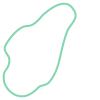

In [5]:
#Interpolate the SVG Path into waypoints
points = list()
svg_length = center_line_path.length()
for i in range(DESIRED_NUMBER_WAYPOINTS):
    center_point = center_line_path.point(i/DESIRED_NUMBER_WAYPOINTS)
    center_x, center_y = center_point.real, center_point.imag
    points.append((center_x, center_y))
# svg.path doesn't quite have final point the same as first point so we
# be sure to close the path by repeating the zero coordinate
point = center_line_path.point(0)
points.append((point.real, point.imag))

# Make shapely geometry out of waypoints
ls_source_center_line = LineString(points)

# Scale to desired size
scale_factor = DESIRED_LENGTH / ls_source_center_line.length
ls_source_center_line = affinity.scale(ls_source_center_line, xfact=scale_factor, yfact=scale_factor)
print("Center length: ", ls_source_center_line.length)
# SVG has (always?) mirrored image
ls_source_center_line = affinity.scale(ls_source_center_line, xfact=-1.0)
ls_source_center_line

# Fit the track to another similar track

Usually applicable for race tracks vs training tracks for virtual summit

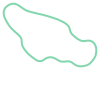

In [6]:
# Load the target shape
target_track_waypoints = np.load("tracks/%s.npy" % target_track_name_npy)
ls_target_center_line = LineString(target_track_waypoints[:,0:2])
target_track_width = Point(target_track_waypoints[0,2:4]).distance(Point(target_track_waypoints[0,4:6]))
ls_target_center_line

In [7]:
from bayes_opt import BayesianOptimization

# Bayes tuning
N_ITER=30
INIT_POINTS=800
KAPPA=1

# Convert source and target to polygons for optimization function
p_source = Polygon(ls_source_center_line)
p_target = Polygon(ls_target_center_line)
# Initialize our optimization by forcing at least one overlapping point
target_center = p_target.centroid
source_center = p_source.centroid
p_source = affinity.translate(p_source, 
                              xoff=(target_center.x - source_center.x),
                              yoff=(target_center.y - source_center.y))

minx, miny, maxx, maxy = p_target.bounds
mintx = minx - target_center.x
maxtx = maxx - target_center.x
minty = miny - target_center.y
maxty = maxy - target_center.y
pbounds = {
    'r': (-180,180),      # degree of rotation
    'x': (mintx, maxtx),  # centroid definitely won't move outside of target bounds
    'y': (minty, maxty)
}
print("Searching pbounds: ", pbounds)
print("Target bounds: ", p_target.bounds)

def coincident_area(r,x,y):
    global p_source
    global p_target
    p_source_t = affinity.translate(p_source, xoff=x, yoff=y)
    p_source_r = affinity.rotate(p_source_t, r, origin='centroid')
    intersection = p_source_r.intersection(p_target)
    difference = p_source_r.difference(p_target)
    return intersection.area - 20*difference.area # penalize overhang so optimization doesn't find some odd orientation that has largest overlap


# Start the optimization
optimizer = BayesianOptimization(f=coincident_area, pbounds=pbounds, random_state=1)
optimizer.maximize(n_iter=N_ITER, init_points=INIT_POINTS, kappa=KAPPA)

Searching pbounds:  {'r': (-180, 180), 'x': (-3.9178009605753266, 4.185625078643576), 'y': (-2.5232075143266472, 2.9531770062040534)}
Target bounds:  (0.9167823195457458, -2.790287494659424, 9.020208358764648, 2.686097025871277)
|   iter    |  target   |     r     |     x     |     y     |
-------------------------------------------------------------
|  1        | -269.0    | -29.87    |  1.919    | -2.523    |
|  2        | -357.8    | -71.16    | -2.729    | -2.018    |
|  3        | -112.4    | -112.9    | -1.118    | -0.3504   |
|  4        | -141.2    |  13.97    | -0.5209   |  1.229    |
|  5        | -229.3    | -106.4    |  3.198    | -2.373    |
|  6        | -84.93    |  61.37    | -0.5362   |  0.5364   |
|  7        | -193.9    | -129.5    | -2.313    |  1.862    |
|  8        | -200.1    |  168.6    | -1.378    |  1.268    |
|  9        | -292.9    |  135.5    |  3.332    | -2.057    |
|  10       | -273.3    | -165.9    | -2.542    |  2.286    |
|  11       | -258.7    | -

|  113      | -368.9    | -63.23    |  3.156    |  2.103    |
|  114      | -363.1    |  13.84    |  3.105    |  2.678    |
|  115      | -235.1    |  117.5    |  3.003    | -1.982    |
|  116      | -194.7    |  54.47    |  1.783    |  0.8187   |
|  117      | -240.9    |  107.9    | -3.638    |  1.695    |
|  118      | -253.2    |  83.42    | -1.813    | -1.115    |
|  119      | -152.2    |  47.63    | -1.12     |  1.839    |
|  120      | -339.9    | -19.39    |  2.425    |  2.901    |
|  121      | -250.4    | -71.91    | -2.759    |  2.413    |
|  122      | -318.4    |  14.96    |  3.981    |  0.9631   |
|  123      | -160.8    |  177.8    |  0.5072   |  0.3597   |
|  124      | -264.4    | -131.2    | -1.035    | -2.38     |
|  125      | -196.9    | -122.3    |  2.124    | -2.357    |
|  126      | -291.6    | -48.04    |  3.07     |  1.27     |
|  127      | -205.5    |  68.74    | -2.389    | -0.1032   |
|  128      | -312.7    |  29.37    |  4.103    | -1.407    |
|  129  

|  197      | -143.6    | -103.1    |  2.3      | -0.833    |
|  198      | -141.3    |  83.97    |  2.115    | -1.311    |
|  199      | -326.7    | -102.9    | -2.306    | -1.743    |
|  200      | -336.5    | -44.25    | -3.702    | -1.916    |
|  201      | -209.8    |  62.84    |  2.563    | -2.082    |
|  202      | -213.8    | -96.59    | -2.235    |  2.5      |
|  203      | -81.67    |  76.07    |  0.5706   | -0.8555   |
|  204      | -271.7    |  120.5    | -0.3903   |  2.534    |
|  205      | -193.5    |  74.18    | -0.04411  | -1.832    |
|  206      | -250.5    |  171.4    | -2.623    | -1.414    |
|  207      | -200.6    | -24.77    | -0.6424   | -1.72     |
|  208      | -138.0    |  82.55    | -2.388    |  1.003    |
|  209      | -124.5    |  91.55    | -2.21     |  0.7678   |
|  210      | -169.4    |  89.61    |  1.254    |  0.7469   |
|  211      | -378.4    | -73.63    |  2.011    |  2.654    |
|  212      | -259.8    | -26.8     |  2.421    | -2.216    |
|  213  

|  297      | -188.4    |  51.92    | -1.076    | -1.268    |
|  298      | -135.7    | -23.8     | -0.8185   |  0.04954  |
|  299      | -214.6    |  172.6    | -0.9651   |  1.718    |
|  300      | -264.9    |  19.0     |  3.287    | -0.5793   |
|  301      | -237.7    | -91.61    |  3.465    | -2.285    |
|  302      | -150.0    |  162.3    |  0.591    | -0.4621   |
|  303      | -259.8    |  178.2    | -3.445    |  0.3065   |
|  304      | -178.5    | -168.8    |  0.7107   | -1.535    |
|  305      | -394.5    |  47.15    |  4.031    |  2.268    |
|  306      | -253.0    | -17.34    |  1.823    |  1.735    |
|  307      | -208.3    | -1.856    |  0.3651   | -1.697    |
|  308      | -231.5    | -47.02    | -2.765    |  1.458    |
|  309      | -225.4    | -8.275    | -0.2803   |  2.329    |
|  310      | -182.3    |  9.943    | -0.6028   | -1.051    |
|  311      | -229.5    | -154.1    | -0.5295   | -2.382    |
|  312      | -332.9    | -75.18    |  0.1624   |  2.767    |
|  313  

|  381      | -136.2    | -151.2    | -0.01441  | -0.08253  |
|  382      | -140.6    |  62.09    | -0.2815   |  1.334    |
|  383      | -203.7    |  65.39    |  1.731    |  0.8645   |
|  384      | -302.1    | -125.6    |  2.247    |  1.754    |
|  385      | -232.7    |  145.5    | -2.023    | -1.556    |
|  386      | -224.6    | -39.2     | -1.32     |  1.943    |
|  387      | -196.0    |  40.87    |  2.241    | -0.1811   |
|  388      | -252.9    | -144.2    | -2.986    | -0.4783   |
|  389      | -289.7    | -110.2    |  2.733    |  0.7606   |
|  390      | -206.5    |  67.98    |  0.06187  | -2.04     |
|  391      | -176.9    | -95.37    | -0.1772   | -1.436    |
|  392      | -262.4    | -170.8    |  1.993    |  1.447    |
|  393      | -191.0    | -61.06    |  2.917    | -0.1769   |
|  394      | -163.1    |  131.3    |  1.407    |  0.6588   |
|  395      | -284.3    | -107.7    |  0.3733   |  2.375    |
|  396      | -391.8    | -70.2     |  3.14     |  2.453    |
|  397  

|  468      | -145.0    | -45.81    |  1.839    | -0.02793  |
|  469      | -377.1    |  37.88    |  4.108    |  1.715    |
|  470      | -325.0    | -59.66    | -3.197    | -1.511    |
|  471      | -176.9    |  9.667    | -0.5378   |  1.862    |
|  472      | -263.5    |  156.0    | -2.476    |  2.187    |
|  473      | -331.6    |  164.7    |  3.857    | -2.316    |
|  474      | -323.3    | -159.3    | -3.871    | -0.8108   |
|  475      | -163.2    | -159.9    | -1.537    | -0.5735   |
|  476      | -156.1    |  163.3    | -0.05286  | -0.9995   |
|  477      | -232.4    |  1.082    |  1.296    | -1.914    |
|  478      | -392.6    |  92.9     |  2.986    |  2.1      |
|  479      | -122.2    |  140.6    | -0.8236   | -0.09276  |
|  480      | -244.3    | -143.4    | -2.088    |  2.796    |
|  481      | -397.2    | -77.54    |  3.435    |  2.354    |
|  482      | -274.1    |  152.1    | -2.652    |  2.294    |
|  483      | -210.6    |  47.52    | -2.211    | -0.6332   |
|  484  

|  549      | -251.5    |  74.13    |  3.334    | -0.7207   |
|  550      | -182.4    |  10.08    |  1.353    |  0.7314   |
|  551      | -162.8    | -96.67    | -0.4591   | -1.164    |
|  552      | -300.7    |  124.4    |  4.078    | -2.159    |
|  553      | -71.2     |  77.01    | -1.243    |  0.9019   |
|  554      | -64.78    | -87.07    |  1.358    | -0.4907   |
|  555      | -399.0    | -73.86    |  3.471    |  2.638    |
|  556      | -212.8    |  40.88    | -2.18     |  2.621    |
|  557      | -145.9    |  90.16    |  2.169    | -1.364    |
|  558      | -140.4    |  118.9    | -1.972    |  0.9358   |
|  559      | -155.8    |  75.87    |  2.098    | -0.386    |
|  560      | -319.8    |  93.54    |  3.399    |  0.6937   |
|  561      | -320.0    | -147.5    | -2.873    | -1.947    |
|  562      | -215.0    | -117.8    | -2.893    |  1.739    |
|  563      | -248.0    | -165.8    | -1.96     |  2.291    |
|  564      | -293.1    |  170.5    |  0.9882   |  2.823    |
|  565  

|  701      | -199.9    | -28.82    |  0.9668   |  1.416    |
|  702      | -149.4    |  128.6    |  1.602    | -1.225    |
|  703      | -206.9    |  153.3    |  2.413    | -0.8399   |
|  704      | -230.8    | -70.21    |  3.223    | -1.833    |
|  705      | -156.1    |  48.05    | -1.667    |  2.007    |
|  706      | -177.1    | -48.77    |  2.025    | -1.469    |
|  707      | -209.8    | -6.679    |  2.594    | -0.3491   |
|  708      | -246.4    | -121.8    |  1.341    |  1.602    |
|  709      | -278.6    | -79.13    | -0.2602   |  2.408    |
|  710      | -185.0    |  133.9    |  1.813    |  0.7128   |
|  711      | -291.3    |  114.3    |  3.437    | -2.509    |
|  712      | -195.1    | -37.0     |  0.6315   |  1.496    |
|  713      | -141.1    | -148.5    | -0.6784   | -0.9919   |
|  714      | -162.2    | -27.54    |  0.1175   |  1.091    |
|  715      | -164.5    | -1.355    |  1.11     |  0.6665   |
|  716      | -320.4    | -25.8     | -3.877    | -1.458    |
|  717  

|  801      |  0.3658   |  88.87    | -0.2327   | -0.006096 |
|  802      |  0.711    |  88.76    | -0.2031   |  0.1427   |
|  803      | -0.5858   |  88.91    | -0.1584   |  0.1096   |
|  804      |  1.482    |  88.78    | -0.2113   |  0.05014  |
|  805      |  6.665    |  88.83    | -0.3172   |  0.1125   |
|  806      |  10.92    |  88.84    | -0.4178   |  0.1505   |
|  807      |  13.14    |  88.86    | -0.6029   |  0.2451   |
|  808      |  14.41    |  88.85    | -0.5534   |  0.211    |
|  809      |  8.58     |  88.79    | -0.584    |  0.1678   |
|  810      |  15.71    |  88.97    | -0.5288   |  0.2384   |
|  811      |  14.4     |  88.91    | -0.518    |  0.2524   |
|  812      |  6.874    |  88.98    | -0.5906   |  0.1589   |
|  813      |  13.89    |  89.08    | -0.4965   |  0.2506   |
|  814      |  15.76    |  88.97    | -0.5252   |  0.234    |
|  815      |  15.61    |  88.98    | -0.5177   |  0.2284   |
|  816      |  15.73    |  88.98    | -0.5325   |  0.2414   |
|  817  

In [ ]:
# Apply results of optimization
values = optimizer.max['params']
print(optimizer.max)
values['r'] = 90
p_applied = affinity.translate(p_source, xoff=values['x'], yoff=values['y'])
p_applied = affinity.rotate(p_applied, values['r'], origin='centroid')

# Visually inspect the translated, rotated, and scaled track
import matplotlib.pyplot as plt
tx,ty = p_target.exterior.xy
plt.plot(tx,ty)
sx,sy = p_applied.exterior.xy
plt.plot(sx,sy)
plt.show()


In [ ]:
# Make a poly out of our center line, expanding its dimensions to have outer and inner boundaries
ls_center = p_applied.exterior
poly = ls_center.buffer(target_track_width/2.0)
print("Center Closed: ", ls_center.is_ring)
print("Center Length: ", ls_center.length)
print("Center Bounds: ", ls_center.bounds)
ls_outer = poly.exterior
ls_inner = poly.interiors[0]
print("Outer Length: ", ls_outer.length)
print("Innter Length: ", ls_inner.length)

# Generate final waypoint list as [center_x, center_y, inner_x, inner_y, outer_x, outer_y]
all_waypoints = list()
for i in range(len(ls_center.coords)):
    distance = i / len(ls_center.coords)
    center_point = ls_center.coords[i]
    outer_point = ls_outer.interpolate(distance, normalized=True)
    inner_point = ls_inner.interpolate(distance, normalized=True)
    all_waypoints.append(list(sum((center_point, inner_point.coords[0], outer_point.coords[0]), ())))

poly

## Write out the resulting geometry

In [ ]:
# Save resulting waypoints to file

fname = "./tracks/%s.npy"% source_track_name_svg
np.save(fname, all_waypoints)